# Capstone Project - The Battle of the Neighborhoods
# Venues opportunities  in Las Condes (Santiago, Chile)

### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

The purpose of this Project is to evaluate **new opportunities for future venues in the city of Santiago, Chile**. The client is interested in opening a new venue in Santiago, specifically in the **commune of Las Condes**. They want to know what **type of venue** are the best option.

The Santiago city divides its territory into several communes. We are going to explore the **main communes of Santiago** and then compare with Las Condes to analyze which **communes are the most similar** to the commune in question. With this information we can determine the **most frequent venues** that are present in the similar communes but not in Las Condes, so these venues are **possible niches or future business opportunities**.

### The next image show the communes of Santiago. 
On the right side of the image we can appreciate **Las Condes** (in purple).

In [302]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://assets.eldesconcierto.cl/2020/05/WhatsApp-Image-2020-04-28-at-12.07.11-1024x683-2.jpeg")

## Data <a name="data"></a>

The data that we will use to solve the problem are:
 * **Venues** of the different communes (**Foursquare API**)
 * Communes parameters: **Latitude, longitude, area and population** of the different communes. This information will be obtained from https://es.wikipedia.org/wiki/Anexo:Comunas_de_Chile
 * **UF value per square meter** of a property or real estate (in this case departments) of the communes. The information source is https://www.buenainversion.cl/blog/valor-metro-cuadrado/
 
**Use of Data:**
1. First we are going to **load the communes parameters** (latitude, longitude, area, population and UF/m²). Then we wrangling this data. 
2. We assume that the commune area is circular, so we can obtain a **characteristic radius per commune**. We will use 3/4 of that radius, limiting the exploration radius to 5 km, to **explore with Foursquare API** the several communes and get the venues around them.
3. Then we **explore the communes** to obtain the venues with the Foursquare API and **normalize the venues per commune by the exploration area** (circular area, function of exploration radius) to get the different types of venues per km² for each commune.
4. We use the one hot representation of the normalized venues to **group the communes into six groups** and visualize the results in a folium map.
5. We want to know which are the **three most similar communes to Las Condes** based on the **one hot representation** vector and the similarity in cost of living or **economic situation** in the commune, for this we use the UF/m². We use both indicators to get the most similar communes.
6. Finally, we get the **ten most frequent venues** for Las Condes and the three similar communes and analyze which venues are present in those communes but not in Las Condes, so those venues are **possible niches or business opportunities**.

## Methodology and Data Analysis <a name="methodology"></a>

In the next section we **address the problem** with the mentioned data by following the six points outlined above.

This section is the main of the project, where we **clean, manipulate, explore and analyze the data** to solve the problem.

### Import the libraries

In [2]:
import numpy as np

import pandas as pd 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json
 
import requests 
from pandas.io.json import json_normalize 

import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

from sklearn.cluster import KMeans

import csv

!pip install dms2dec
from dms2dec.dms_convert import dms2dec

import string

!pip install folium
import folium

import math

print('Libraries imported.')

Libraries imported.


## 1. Load communes parameters and clean the data

This source give us the communes of all Chile.

In [3]:
df1 = pd.read_html("https://es.wikipedia.org/wiki/Anexo:Comunas_de_Chile")[0]

df1.head()

,CUT (Código Único Territorial),Nombre,Unnamed: 2,Provincia,Región,Superficie(km²),Población2020,Densidad(hab./km²),IDH 2020,IDH 2020.1,Latitud,Longitud
0,15101,Arica,NaN,Arica,Arica y Parinacota,4.7994,247.552,51.60,0.866,Alto,"-18°27'18""","-70°17'24"""
1,15102,Camarones,NaN,Arica,Arica y Parinacota,3.927,1.233,0.31,0.791,Alto,"-19°1'1.2""","-69°52'1.2"""
2,15201,Putre,NaN,Parinacota,Arica y Parinacota,5.9025,2.515,0.43,0.817,Alto,"-18°12'0""","-69°34'58.8"""
3,15202,General Lagos,NaN,Parinacota,Arica y Parinacota,2.2444,810.000,0.36,0.773,Medio,"-17°39'10.8""","-69°38'6"""
4,1101,Iquique,NaN,Iquique,Tarapacá,2.2421,223.463,996.00,0.826,Alto,"-20°14'38.4""","-70°8'20.4"""


In [4]:
df1 = df1[['Nombre', 'Provincia', 'Superficie(km²)', 'Población2020', 'Latitud', 'Longitud']]
df1.head()

,Nombre,Provincia,Superficie(km²),Población2020,Latitud,Longitud
0,Arica,Arica,4.7994,247.552,"-18°27'18""","-70°17'24"""
1,Camarones,Arica,3.927,1.233,"-19°1'1.2""","-69°52'1.2"""
2,Putre,Parinacota,5.9025,2.515,"-18°12'0""","-69°34'58.8"""
3,General Lagos,Parinacota,2.2444,810.000,"-17°39'10.8""","-69°38'6"""
4,Iquique,Iquique,2.2421,223.463,"-20°14'38.4""","-70°8'20.4"""


In [5]:
df1.columns = ['Commune', 'Province', 'Area km2', 'Population', 'Latitude', 'Longitude']
df1.head()

,Commune,Province,Area km2,Population,Latitude,Longitude
0,Arica,Arica,4.7994,247.552,"-18°27'18""","-70°17'24"""
1,Camarones,Arica,3.927,1.233,"-19°1'1.2""","-69°52'1.2"""
2,Putre,Parinacota,5.9025,2.515,"-18°12'0""","-69°34'58.8"""
3,General Lagos,Parinacota,2.2444,810.000,"-17°39'10.8""","-69°38'6"""
4,Iquique,Iquique,2.2421,223.463,"-20°14'38.4""","-70°8'20.4"""


### Select only the communes of Santiago

In [7]:
df_stgo = df1[df1['Province'] == 'Santiago'].copy()
df_stgo.reset_index(drop=True, inplace=True)
df_stgo.head()

,Commune,Province,Area km2,Population,Latitude,Longitude
0,Santiago,Santiago,23.2,503.147,"-33°26'14""","-70°39'26"""
1,Cerrillos,Santiago,21,88.956,"-33°30'0""","-70°43'0"""
2,Cerro Navia,Santiago,11,142.465,"-33°25'19.2""","-70°44'6"""
3,Conchalí,Santiago,10.7,139.195,"-33°22'48""","-70°40'30"""
4,El Bosque,Santiago,14.2,172.000,"-33°34'1.2""","-70°40'30"""


In [8]:
df_stgo.drop('Province', 1, inplace=True)
df_stgo.head()

,Commune,Area km2,Population,Latitude,Longitude
0,Santiago,23.2,503.147,"-33°26'14""","-70°39'26"""
1,Cerrillos,21,88.956,"-33°30'0""","-70°43'0"""
2,Cerro Navia,11,142.465,"-33°25'19.2""","-70°44'6"""
3,Conchalí,10.7,139.195,"-33°22'48""","-70°40'30"""
4,El Bosque,14.2,172.000,"-33°34'1.2""","-70°40'30"""


#### Then we convert the population to the correct number and latitude and longitude to a useful format.

In [9]:
df_stgo['Population'] = df_stgo['Population'].apply(lambda x: x*1000).astype(int)

df_stgo = (df_stgo.set_index(['Commune', 'Area km2', 'Population', 'Longitude'])
   .apply(lambda x: x.str[1:] + 'S')
   .reset_index()) 

df_stgo = (df_stgo.set_index(['Commune', 'Area km2', 'Population', 'Latitude'])
   .apply(lambda x: x.str[1:] + 'W')
   .reset_index()) 

df_stgo.head()

,Commune,Area km2,Population,Latitude,Longitude
0,Santiago,23.2,503147,"33°26'14""S","70°39'26""W"
1,Cerrillos,21,88956,"33°30'0""S","70°43'0""W"
2,Cerro Navia,11,142465,"33°25'19.2""S","70°44'6""W"
3,Conchalí,10.7,139195,"33°22'48""S","70°40'30""W"
4,El Bosque,14.2,172000,"33°34'1.2""S","70°40'30""W"


#### With the dms2dec library we convert latitude and longitude from degrees minutes seconds to decimal degrees, because that format use the Foursquare API.

In [10]:
for i, row in enumerate(df_stgo['Latitude']):
    df_stgo.iloc[i, 3] = dms2dec(row)
for i, row in enumerate(df_stgo['Longitude']):
    df_stgo.iloc[i, 4] = dms2dec(row)
    
df_stgo.head()

,Commune,Area km2,Population,Latitude,Longitude
0,Santiago,23.2,503147,-33.4372,-70.6572
1,Cerrillos,21,88956,-33.5,-70.7167
2,Cerro Navia,11,142465,-33.422,-70.735
3,Conchalí,10.7,139195,-33.38,-70.675
4,El Bosque,14.2,172000,-33.567,-70.675


### Load UF value per square meter of a property or real estate (departments) of the communes.

In [11]:
df_m2 = pd.read_html(io = "https://www.buenainversion.cl/blog/valor-metro-cuadrado/", decimal=",", thousands='.')[1]
df_m2.head()

,COMUNA,Valor UF/m22016,Valor UF/m22019,Crecimiento 2016-2019
0,BUIN,33.9,40.8,"20,35%"
1,CERRILLOS,32.8,41.8,"27,44%"
2,COLINA,63.4,64.6,"1,89%"
3,CONCHALÍ,38.4,54.9,"42,97%"
4,ESTACIÓN CENTRAL,46.4,52.3,"12,72%"


In [12]:
df_m2.drop(['Valor UF/m22016', 'Crecimiento 2016-2019'], 1, inplace=True)
df_m2.head()

,COMUNA,Valor UF/m22019
0,BUIN,40.8
1,CERRILLOS,41.8
2,COLINA,64.6
3,CONCHALÍ,54.9
4,ESTACIÓN CENTRAL,52.3


In [13]:
df_m2.columns = ['Commune', 'UF/m2']
df_m2.head()

,Commune,UF/m2
0,BUIN,40.8
1,CERRILLOS,41.8
2,COLINA,64.6
3,CONCHALÍ,54.9
4,ESTACIÓN CENTRAL,52.3


**Change the communes names to have the same as df_stgo.**

In [14]:
def title(x):
    return x.str.title()

df_m2 = (df_m2.set_index(['UF/m2'])
   .apply(title)
   .reset_index()) 

df_m2.head()

,UF/m2,Commune
0,40.8,Buin
1,41.8,Cerrillos
2,64.6,Colina
3,54.9,Conchalí
4,52.3,Estación Central


In [15]:
df_m2 = df_m2[['Commune', 'UF/m2']]
df_m2.head()

,Commune,UF/m2
0,Buin,40.8
1,Cerrillos,41.8
2,Colina,64.6
3,Conchalí,54.9
4,Estación Central,52.3


**We merge both data.**

In [18]:
df_stgo_m2 = pd.merge(df_stgo, df_m2, on='Commune')
df_stgo_m2.head()

,Commune,Area km2,Population,Latitude,Longitude,UF/m2
0,Santiago,23.2,503147,-33.4372,-70.6572,63.9
1,Cerrillos,21,88956,-33.5,-70.7167,41.8
2,Conchalí,10.7,139195,-33.38,-70.675,54.9
3,Estación Central,15,206792,-33.459,-70.699,52.3
4,Huechuraba,44.8,112527,-33.368,-70.634,50.0


In [19]:
df_stgo_m2.iloc[10, 1] = 1024

**We copy the data to work with it.**

In [20]:
df_stgo2 = df_stgo_m2.copy()
df_stgo2 = df_stgo2.sort_values(['Commune']).reset_index(drop=True)
df_stgo2

,Commune,Area km2,Population,Latitude,Longitude,UF/m2
0,Cerrillos,21,88956,-33.5,-70.7167,41.8
1,Conchalí,10.7,139195,-33.38,-70.675,54.9
2,Estación Central,15,206792,-33.459,-70.699,52.3
3,Huechuraba,44.8,112527,-33.368,-70.634,50.0
4,Independencia,7,142065,-33.413,-70.666,53.0
5,La Cisterna,10,100434,-33.529,-70.663,51.8
6,La Florida,70.2,402433,-33.525,-70.538,54.9
7,La Reina,23,100252,-33.443,-70.532,78.0
8,Las Condes,99,330759,-33.4167,-70.5833,94.9
9,Lo Barnechea,1024,124076,-33.35,-70.5167,92.1


### Map of the communes of Santiago that we will analyze.

The red point corresponds to Las Condes

In [23]:
lat_stgo = -33.4513
long_stgo = -70.6653

# create map of Santiago using latitude and longitude values
map_stgo = folium.Map(location=[lat_stgo, long_stgo], zoom_start=11)

# add markers to map
for lat, lng, commune in zip(df_stgo2['Latitude'], df_stgo2['Longitude'], df_stgo2['Commune']):
    label = '{}'.format(commune)
    label = folium.Popup(label, parse_html=True)
    if commune == 'Las Condes':
        colorc = 'red'
        fill = 'red'
    else:
        colorc = 'blue'
        fill = '#3186cc'
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=colorc,
        fill=True,
        fill_color=fill,
        fill_opacity=0.7,
        parse_html=False).add_to(map_stgo)  
    
map_stgo

## 2. Characteristic Radius per commune

We assume that the commune area is circular, so we can obtain a characteristic radius per commune. 

In [28]:
df_area = df_stgo2[['Area km2']].copy()
df_area['Area km2'] = df_area['Area km2'].astype(float)

**We obtain the radius based on the commune area.**

In [29]:
def radio(x):
    r = np.sqrt(x/math.pi)
    return r

df_area['Radius km'] = df_area.apply(radio).round(2)

In [30]:
R_max = 5000 # 5000 m (max exploration radius to explore the communes)

**We get the exploration radius and the corresponds exploration area.**

For the exploration radius we use 3/4 of the characteristic radius and limit the radius to 5 km.

In [31]:
df_area['R Exp(m)'] = df_area['Radius km'].apply(lambda x: x*3/4*1000).clip(0, R_max).astype(int)
df_area['A Exp km2'] = df_area['R Exp(m)'].apply(lambda x: np.pi*(x/1000)**2).round(1)
df_area.head()

,Area km2,Radius km,R Exp(m),A Exp km2
0,21.0,2.59,1942,11.8
1,10.7,1.85,1387,6.0
2,15.0,2.19,1642,8.5
3,44.8,3.78,2835,25.2
4,7.0,1.49,1117,3.9


## 3. Explore the venues per commune using the exploration radius.

### Foursquare credentials and version

In [32]:
CLIENT_ID = 'EGXIZLYDPTSKH2OCWHKB1ZERVNPVIFLRJBJX1SBLOSIMFEBN' 
CLIENT_SECRET = 'K52ANBX5ALW2CQI0NNJDQWLLKNLWPKLNL0B5K3WUIEZ3QVIU' 
VERSION = '20180605' # Foursquare API version
LIMIT = 300

**Function to obtain the venues per commune in the exploration area.**

In [37]:
def getNearbyVenues(names, latitudes, longitudes, radius):
    
    venues_list=[]
    for name, lat, lng, radio in zip(names, latitudes, longitudes, radius):
        offset = 0
        add = True
        while (offset < LIMIT and add == True):
            add = False
            # create the API request URL
            url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&offset={}&limit={}'.format(
                CLIENT_ID, 
                CLIENT_SECRET, 
                VERSION, 
                lat, 
                lng, 
                radio,
                offset,
                100)

            # make the GET request
            results = requests.get(url).json()["response"]['groups'][0]['items']

            # return only relevant information for each nearby venue
            for v in results:
                list_venue = [(
                name, 
                lat, 
                lng, 
                v['venue']['name'], 
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],  
                v['venue']['categories'][0]['name'])]
                if list_venue not in venues_list:
                    venues_list.append(list_venue)
                    add = True
                    
            offset += 100
                
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Commune', 
                  'Commune Latitude', 
                  'Commune Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

### Venues per Commune

In [38]:
stgo_venues = getNearbyVenues(names=df_stgo2['Commune'],
                                   latitudes=df_stgo2['Latitude'],
                                   longitudes=df_stgo2['Longitude'],
                                   radius=df_area['R Exp(m)'] 
                             )
stgo_venues.head()

,Commune,Commune Latitude,Commune Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Cerrillos,-33.5,-70.716667,Botillería Don Pato,-33.504674,-70.719608,Liquor Store
1,Cerrillos,-33.5,-70.716667,Fu Wen Sushi Bar,-33.512210,-70.719848,Sushi Restaurant
2,Cerrillos,-33.5,-70.716667,Calfucura Buffet,-33.492065,-70.727675,South American Restaurant
3,Cerrillos,-33.5,-70.716667,Parque Bicentenario Cerrillos,-33.496736,-70.699234,Park
4,Cerrillos,-33.5,-70.716667,Johnny Rockets,-33.516240,-70.716165,Burger Joint


In [39]:
stgo_venues.shape

(2170, 7)

We obtained 2170 venues in total.

**Number of venues per commune.**

In [40]:
stgo_venues.groupby('Commune').count()['Venue']

Commune
Cerrillos            45
Conchalí             21
Estación Central     69
Huechuraba           43
Independencia        34
La Cisterna          53
La Florida           45
La Reina             65
Las Condes          217
Lo Barnechea         92
Macul                73
Maipú               145
Peñalolén            58
Providencia         200
Pudahuel            179
Quilicura            59
Quinta Normal        32
Recoleta             33
San Joaquín          27
San Miguel           71
Santiago            224
Vitacura            225
Ñuñoa               160
Name: Venue, dtype: int64

### One hot encoding of venues

In [41]:
# one hot encoding
stgo_onehot = pd.get_dummies(stgo_venues[['Venue Category']], prefix="", prefix_sep="")

# add commune column back to dataframe
stgo_onehot['Commune'] = stgo_venues['Commune'] 

columns = stgo_onehot.columns.values.tolist()
columns.remove('Commune')
col_names = ['Commune'] + columns
stgo_onehot = stgo_onehot[col_names]
stgo_onehot.head()

,Commune,Adult Boutique,Airport,American Restaurant,Amphitheater,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bar,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bistro,Board Shop,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Cafeteria,Café,Campground,Candy Store,Cemetery,Cheese Shop,Chinese Restaurant,Chocolate Shop,Circus,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Bookstore,College Rec Center,Comfort Food Restaurant,Concert Hall,Convenience Store,Convention Center,Cosmetics Shop,Coworking Space,Creperie,Cultural Center,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distillery,Donut Shop,Electronics Store,Empanada Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Football Stadium,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Hardware Store,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hockey Field,Hostel,Hot Dog Joint,Hotel,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Internet Cafe,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Knitting Store,Korean Restaurant,Latin American Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts School,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Molecular Gastronomy Restaurant,Motel,Motorcycle Shop,Mountain,Movie Theater,Moving Target,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,Neighborhood,Nightclub,Office,Organic Grocery,Other Great Outdoors,Outdoors & Recreation,Outlet Mall,Paper / Office Supplies Store,Park,Pastelaria,Pedestrian Plaza,Performing Arts Venue,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Photography Lab,Pie Shop,Pizza Place,Plane,Planetarium,Playground,Plaza,Pool,Pool Hall,Pub,Public Art,Racecourse,Racetrack,Record Shop,Recording Studio,Recreation Center,Recycling Facility,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shoe Store,Shop & Service,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Club,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Swiss Restaurant,Tapas Restaurant,Tattoo Parlor,Tea Room,Tennis Court,Tennis Stadium,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Thrift / Vintage Store,Toy / Game Store,Track,Track Stadium,Trail,Tunnel,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Veterinarian,Video Game Store,Video Store,Vietnamese Restaurant,Vineyard,Volleyball Court,Water Park,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo Exhibit
0,Cerrillos,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

### We group the venues by commune

In [42]:
stgo_grouped = stgo_onehot.groupby('Commune').sum().reset_index()
stgo_grouped.head()

,Commune,Adult Boutique,Airport,American Restaurant,Amphitheater,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bar,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bistro,Board Shop,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Cafeteria,Café,Campground,Candy Store,Cemetery,Cheese Shop,Chinese Restaurant,Chocolate Shop,Circus,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Bookstore,College Rec Center,Comfort Food Restaurant,Concert Hall,Convenience Store,Convention Center,Cosmetics Shop,Coworking Space,Creperie,Cultural Center,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distillery,Donut Shop,Electronics Store,Empanada Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Football Stadium,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Hardware Store,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hockey Field,Hostel,Hot Dog Joint,Hotel,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Internet Cafe,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Knitting Store,Korean Restaurant,Latin American Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts School,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Molecular Gastronomy Restaurant,Motel,Motorcycle Shop,Mountain,Movie Theater,Moving Target,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,Neighborhood,Nightclub,Office,Organic Grocery,Other Great Outdoors,Outdoors & Recreation,Outlet Mall,Paper / Office Supplies Store,Park,Pastelaria,Pedestrian Plaza,Performing Arts Venue,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Photography Lab,Pie Shop,Pizza Place,Plane,Planetarium,Playground,Plaza,Pool,Pool Hall,Pub,Public Art,Racecourse,Racetrack,Record Shop,Recording Studio,Recreation Center,Recycling Facility,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shoe Store,Shop & Service,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Club,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Swiss Restaurant,Tapas Restaurant,Tattoo Parlor,Tea Room,Tennis Court,Tennis Stadium,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Thrift / Vintage Store,Toy / Game Store,Track,Track Stadium,Trail,Tunnel,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Veterinarian,Video Game Store,Video Store,Vietnamese Restaurant,Vineyard,Volleyball Court,Water Park,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo Exhibit
0,Cerrillos,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2,0,0,0,0,0,0,2,0,0,0,0,1,0,0,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,4,0,0,0,0,0,2,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [43]:
stgo_grouped.shape

(23, 263)

**We obtained 263 different venues.**

### Then we normalize the venues per commune by the exploration area to obtain the venues per km².

In [45]:
stgo_norm = stgo_grouped.iloc[:,1:].div(df_area['A Exp km2'], axis=0)
col_names = stgo_grouped.columns.values.tolist()
stgo_norm['Commune'] = stgo_grouped['Commune']
stgo_norm = stgo_norm[col_names]
stgo_norm.head()

,Commune,Adult Boutique,Airport,American Restaurant,Amphitheater,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bar,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bistro,Board Shop,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Cafeteria,Café,Campground,Candy Store,Cemetery,Cheese Shop,Chinese Restaurant,Chocolate Shop,Circus,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Bookstore,College Rec Center,Comfort Food Restaurant,Concert Hall,Convenience Store,Convention Center,Cosmetics Shop,Coworking Space,Creperie,Cultural Center,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distillery,Donut Shop,Electronics Store,Empanada Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Football Stadium,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Hardware Store,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hockey Field,Hostel,Hot Dog Joint,Hotel,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Internet Cafe,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Knitting Store,Korean Restaurant,Latin American Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts School,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Molecular Gastronomy Restaurant,Motel,Motorcycle Shop,Mountain,Movie Theater,Moving Target,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,Neighborhood,Nightclub,Office,Organic Grocery,Other Great Outdoors,Outdoors & Recreation,Outlet Mall,Paper / Office Supplies Store,Park,Pastelaria,Pedestrian Plaza,Performing Arts Venue,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Photography Lab,Pie Shop,Pizza Place,Plane,Planetarium,Playground,Plaza,Pool,Pool Hall,Pub,Public Art,Racecourse,Racetrack,Record Shop,Recording Studio,Recreation Center,Recycling Facility,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shoe Store,Shop & Service,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Club,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Swiss Restaurant,Tapas Restaurant,Tattoo Parlor,Tea Room,Tennis Court,Tennis Stadium,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Thrift / Vintage Store,Toy / Game Store,Track,Track Stadium,Trail,Tunnel,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Veterinarian,Video Game Store,Video Store,Vietnamese Restaurant,Vineyard,Volleyball Court,Water Park,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo Exhibit
0,Cerrillos,0.0,0.084746,0.084746,0.0,0.0,0.000000,0.084746,0.0,0.0,0.0,0.084746,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.084746,0.000000,0.0,0.0,0.000000,0.0,0.0,0.169492,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.169492,0.0,0.0,0.000000,0.0,0.084746,0.

## 4. Group the communes into six groups using the normalized vector.

In [47]:
# set number of clusters
kclusters = 6

stgo_grouped_clustering = stgo_norm.drop('Commune', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(stgo_grouped_clustering)
kmeans.labels_

array([1, 1, 1, 1, 4, 3, 1, 1, 1, 1, 3, 1, 1, 0, 1, 1, 1, 1, 1, 3, 2, 2,
       5])

**Communes and cluster:**

In [48]:
df_cluster = stgo_grouped[['Commune']].copy()
df_cluster['Cluster'] = kmeans.labels_
df_cluster = pd.merge(df_cluster, df_stgo2[['Commune', 'Latitude', 'Longitude']], on='Commune')
df_cluster.head()

,Commune,Cluster,Latitude,Longitude
0,Cerrillos,1,-33.5,-70.7167
1,Conchalí,1,-33.38,-70.675
2,Estación Central,1,-33.459,-70.699
3,Huechuraba,1,-33.368,-70.634
4,Independencia,4,-33.413,-70.666


### Map of the Clusters

In [49]:
# create map
map_clusters = folium.Map(location=[lat_stgo, long_stgo], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_cluster['Latitude'], df_cluster['Longitude'], df_cluster['Commune'], df_cluster['Cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [71]:
cluster_lascondes = df_cluster[df_cluster['Commune']=='Las Condes']['Cluster']

lascondes_group = df_cluster[df_cluster['Cluster'] == cluster_lascondes.iloc[0]].reset_index(drop=True)
lascondes_group

,Commune,Cluster,Latitude,Longitude
0,Cerrillos,1,-33.5,-70.7167
1,Conchalí,1,-33.38,-70.675
2,Estación Central,1,-33.459,-70.699
3,Huechuraba,1,-33.368,-70.634
4,La Florida,1,-33.525,-70.538
5,La Reina,1,-33.443,-70.532
6,Las Condes,1,-33.4167,-70.5833
7,Lo Barnechea,1,-33.35,-70.5167
8,Maipú,1,-33.5167,-70.7667
9,Peñalolén,1,-33.4862,-70.5333


**We can see 14 communes in the same cluster of Las Condes.**

## 5. Most similar communes to Las Condes

First, we obtain the normalized vector of Las Condes.

In [66]:
las_condes = stgo_norm[stgo_norm['Commune'] == 'Las Condes'].reset_index(drop=True)
las_condes

,Commune,Adult Boutique,Airport,American Restaurant,Amphitheater,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bar,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bistro,Board Shop,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Cafeteria,Café,Campground,Candy Store,Cemetery,Cheese Shop,Chinese Restaurant,Chocolate Shop,Circus,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Bookstore,College Rec Center,Comfort Food Restaurant,Concert Hall,Convenience Store,Convention Center,Cosmetics Shop,Coworking Space,Creperie,Cultural Center,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distillery,Donut Shop,Electronics Store,Empanada Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Football Stadium,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Hardware Store,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hockey Field,Hostel,Hot Dog Joint,Hotel,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Internet Cafe,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Knitting Store,Korean Restaurant,Latin American Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts School,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Molecular Gastronomy Restaurant,Motel,Motorcycle Shop,Mountain,Movie Theater,Moving Target,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,Neighborhood,Nightclub,Office,Organic Grocery,Other Great Outdoors,Outdoors & Recreation,Outlet Mall,Paper / Office Supplies Store,Park,Pastelaria,Pedestrian Plaza,Performing Arts Venue,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Photography Lab,Pie Shop,Pizza Place,Plane,Planetarium,Playground,Plaza,Pool,Pool Hall,Pub,Public Art,Racecourse,Racetrack,Record Shop,Recording Studio,Recreation Center,Recycling Facility,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shoe Store,Shop & Service,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Club,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Swiss Restaurant,Tapas Restaurant,Tattoo Parlor,Tea Room,Tennis Court,Tennis Stadium,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Thrift / Vintage Store,Toy / Game Store,Track,Track Stadium,Trail,Tunnel,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Veterinarian,Video Game Store,Video Store,Vietnamese Restaurant,Vineyard,Volleyball Court,Water Park,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo Exhibit
0,Las Condes,0.0,0.017986,0.017986,0.017986,0.0,0.017986,0.017986,0.0,0.017986,0.0,0.053957,0.017986,0.0,0.0,0.0,0.0,0.035971,0.0,0.0,0.233813,0.017986,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.017986,0.0,0.017986,0.0,0.0,0.035971,0.017986,0.0,0.0,0.035971,0.0,0.0,0.0,0.0,0.0,0.0,0.107914,0.0,0.017986,0.0,0.0,0.035971,0.017986,0.

### Then we calculate the euclidean distance between Las Condes and the other communes using the normalized vectors.

In [67]:
dist_lascondes = (stgo_norm.iloc[:,1:] - np.array(las_condes.iloc[:,1:])).pow(2).sum(1).pow(0.5)
dist_lascondes = dist_lascondes.to_frame()
dist_lascondes.head()

,0
0,0.756025
1,1.059814
2,1.332117
3,0.554703
4,1.810239


In [68]:
dist_lascondes['Commune'] = stgo_norm['Commune']
dist_lascondes.rename(columns={0: 'Euclidean distance'}, inplace=True)
dist_lascondes = dist_lascondes[['Commune', 'Euclidean distance']]
dist_lascondes.head()

,Commune,Euclidean distance
0,Cerrillos,0.756025
1,Conchalí,1.059814
2,Estación Central,1.332117
3,Huechuraba,0.554703
4,Independencia,1.810239


We order the communes according to the Euclidean distance.

In [69]:
dist_lascondes = dist_lascondes.sort_values('Euclidean distance').reset_index(drop=True)
dist_lascondes.head()

,Commune,Euclidean distance
0,Las Condes,0.000000
1,Pudahuel,0.484648
2,Lo Barnechea,0.498146
3,Peñalolén,0.524378
4,La Florida,0.533043


### We can see that the communes of the Las Condes cluster are the same as the 14 most similar to Las Condes according to the Euclidean distance.

In [72]:
lascondes_group

,Commune,Cluster,Latitude,Longitude
0,Cerrillos,1,-33.5,-70.7167
1,Conchalí,1,-33.38,-70.675
2,Estación Central,1,-33.459,-70.699
3,Huechuraba,1,-33.368,-70.634
4,La Florida,1,-33.525,-70.538
5,La Reina,1,-33.443,-70.532
6,Las Condes,1,-33.4167,-70.5833
7,Lo Barnechea,1,-33.35,-70.5167
8,Maipú,1,-33.5167,-70.7667
9,Peñalolén,1,-33.4862,-70.5333


In [74]:
dist_lascondes.iloc[0:15,:]

,Commune,Euclidean distance
0,Las Condes,0.000000
1,Pudahuel,0.484648
2,Lo Barnechea,0.498146
3,Peñalolén,0.524378
4,La Florida,0.533043
5,Maipú,0.535988
6,Huechuraba,0.554703
7,Quilicura,0.563119
8,La Reina,0.699653
9,Cerrillos,0.756025


**Then we select the 8 most similar communes to Las Condes according to the Euclidean distance.**

In [95]:
sim_group = dist_lascondes.iloc[0:9,:].reset_index(drop=True)
sim_group

,Commune,Euclidean distance
0,Las Condes,0.000000
1,Pudahuel,0.484648
2,Lo Barnechea,0.498146
3,Peñalolén,0.524378
4,La Florida,0.533043
5,Maipú,0.535988
6,Huechuraba,0.554703
7,Quilicura,0.563119
8,La Reina,0.699653


Text(0.5, 0, 'Communes')

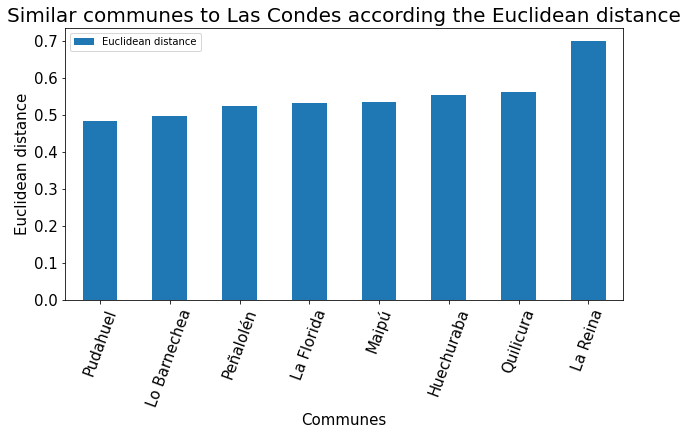

In [96]:
df_sim = sim_group.iloc[1:,:].copy().reset_index(drop=True)
df_sim.set_index('Commune', inplace=True)
ax1 = df_sim.plot.bar(rot=70, figsize=(10, 5), fontsize=15)
ax1.set_title('Similar communes to Las Condes according the Euclidean distance', fontsize = 20)
ax1.set_ylabel('Euclidean distance', fontsize = 15)
ax1.set_xlabel('Communes', fontsize = 15)

### The euclidean distance between the 7 most similar communes is similar, only the last commune (La Reina) has a greater distance.

Then we merge the euclidean distance and the parameters per commune

In [97]:
sim_group2 = pd.merge(sim_group, df_stgo2, on='Commune')
sim_group2

,Commune,Euclidean distance,Area km2,Population,Latitude,Longitude,UF/m2
0,Las Condes,0.000000,99,330759,-33.4167,-70.5833,94.9
1,Pudahuel,0.484648,197,253139,-33.4333,-70.7167,42.9
2,Lo Barnechea,0.498146,1024,124076,-33.35,-70.5167,92.1
3,Peñalolén,0.524378,54,266798,-33.4862,-70.5333,62.0
4,La Florida,0.533043,70.2,402433,-33.525,-70.538,54.9
5,Maipú,0.535988,135.5,578605,-33.5167,-70.7667,49.9
6,Huechuraba,0.554703,44.8,112527,-33.368,-70.634,50.0
7,Quilicura,0.563119,58,254694,-33.361,-70.729,40.0
8,La Reina,0.699653,23,100252,-33.443,-70.532,78.0


### We obtain the difference of UF/m² between Las Condes and similar communes.

We also use the UF/m² difference because this give us a reference of the similarity in the economic situation of the people who live in the communes.

We assume that the **target audience** of the future venue has similar preferences depending on the economic situation.

In [99]:
sim_group2 = (sim_group2.set_index(['Commune', 'Euclidean distance', 'Area km2', 'Population', 'Latitude', 'Longitude'])
   .apply(lambda x: np.absolute(x - 94.9))
   .reset_index())
sim_group2.columns = ['Commune', 'Euclidean distance', 'Area km2', 'Population', 'Latitude', 'Longitude', 'UF/m2 diff']

sim_group2

,Commune,Euclidean distance,Area km2,Population,Latitude,Longitude,UF/m2 diff
0,Las Condes,0.000000,99,330759,-33.416667,-70.583333,0.0
1,Pudahuel,0.484648,197,253139,-33.433333,-70.716667,52.0
2,Lo Barnechea,0.498146,1024,124076,-33.350000,-70.516667,2.8
3,Peñalolén,0.524378,54,266798,-33.486189,-70.533333,32.9
4,La Florida,0.533043,70.2,402433,-33.525000,-70.538000,40.0
5,Maipú,0.535988,135.5,578605,-33.516667,-70.766667,45.0
6,Huechuraba,0.554703,44.8,112527,-33.368000,-70.634000,44.9
7,Quilicura,0.563119,58,254694,-33.361000,-70.729000,54.9
8,La Reina,0.699653,23,100252,-33.443000,-70.532000,16.9


### The UF/m² difference is high in some communes.

Text(0.5, 0, 'Communes')

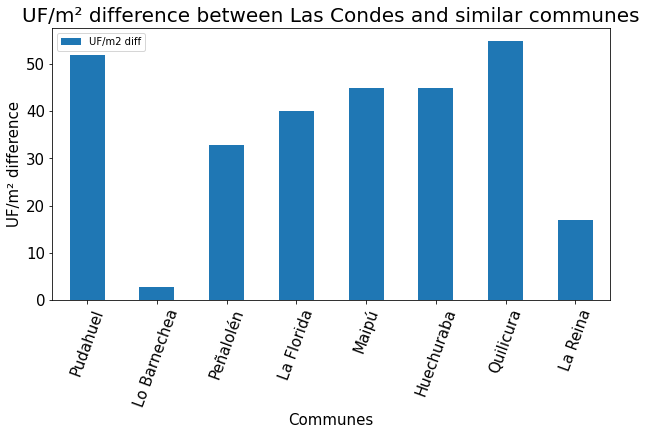

In [103]:
df_m2 = sim_group2.iloc[1:,[0,6]].copy().reset_index(drop=True)
df_m2.set_index('Commune', inplace=True)
ax2 = df_m2.plot.bar(rot=70, figsize=(10, 5), fontsize=15)
ax2.set_title('UF/m² difference between Las Condes and similar communes', fontsize = 20)
ax2.set_ylabel('UF/m² difference', fontsize = 15)
ax2.set_xlabel('Communes', fontsize = 15)

### If we analyze the percentage difference we can see that six communes exceed 35% and some reach values close to 55%. Lo Barnechea and La Reina have values lower than 20%.

Text(0.5, 0, 'Communes')

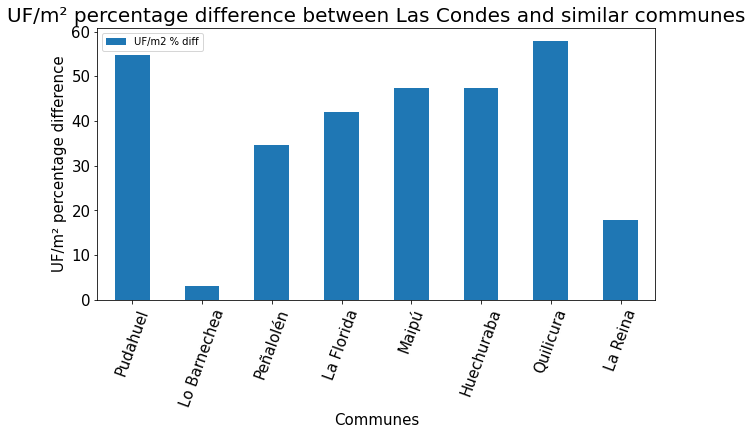

In [110]:
df_m2p = df_m2.apply(lambda x: (x/94.9*100).round(1)).reset_index()
df_m2p.set_index('Commune', inplace=True)
df_m2p.columns = ['UF/m2 % diff']
ax3 = df_m2p.plot.bar(rot=70, figsize=(10, 5), fontsize=15)
ax3.set_title('UF/m² percentage difference between Las Condes and similar communes', fontsize = 20)
ax3.set_ylabel('UF/m² percentage difference', fontsize = 15)
ax3.set_xlabel('Communes', fontsize = 15)

### To obtain the most similar communes to Las Condes we multiply both indicators to obtain only one.

In [114]:
sim_group2['E-m2'] = sim_group2['Euclidean distance'] * sim_group2['UF/m2 diff']
sim_group2

,Commune,Euclidean distance,Area km2,Population,Latitude,Longitude,UF/m2 diff,E-m2
0,Las Condes,0.000000,99,330759,-33.416667,-70.583333,0.0,0.000000
1,Pudahuel,0.484648,197,253139,-33.433333,-70.716667,52.0,25.201701
2,Lo Barnechea,0.498146,1024,124076,-33.350000,-70.516667,2.8,1.394810
3,Peñalolén,0.524378,54,266798,-33.486189,-70.533333,32.9,17.252027
4,La Florida,0.533043,70.2,402433,-33.525000,-70.538000,40.0,21.321714
5,Maipú,0.535988,135.5,578605,-33.516667,-70.766667,45.0,24.119472
6,Huechuraba,0.554703,44.8,112527,-33.368000,-70.634000,44.9,24.906151
7,Quilicura,0.563119,58,254694,-33.361000,-70.729000,54.9,30.915206
8,La Reina,0.699653,23,100252,-33.443000,-70.532000,16.9,11.824136


Text(0.5, 0, 'Communes')

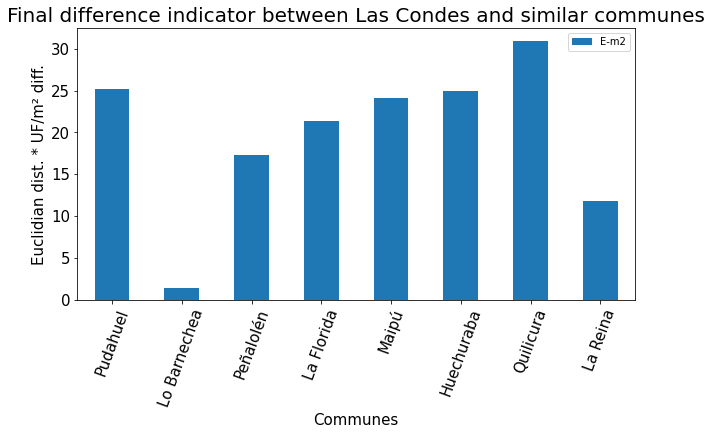

In [117]:
df_Em2 = sim_group2.iloc[1:,[0,7]].copy().reset_index(drop=True)
df_Em2.set_index('Commune', inplace=True)
ax4 = df_Em2.plot.bar(rot=70, figsize=(10, 5), fontsize=15)
ax4.set_title('Final difference indicator between Las Condes and similar communes', fontsize = 20)
ax4.set_ylabel('Euclidian dist. * UF/m² diff.', fontsize = 15)
ax4.set_xlabel('Communes', fontsize = 15)

### The  three most similar communes to Las Condes according the new indicator are Lo Barnechea, La Reina y Peñalolén.

## 6. Future possible niches or business opportunities

In [119]:
sim_group3 = sim_group2.sort_values('E-m2').iloc[0:4, :].reset_index(drop=True)
sim_group3

,Commune,Euclidean distance,Area km2,Population,Latitude,Longitude,UF/m2 diff,E-m2
0,Las Condes,0.000000,99,330759,-33.416667,-70.583333,0.0,0.000000
1,Lo Barnechea,0.498146,1024,124076,-33.350000,-70.516667,2.8,1.394810
2,La Reina,0.699653,23,100252,-33.443000,-70.532000,16.9,11.824136
3,Peñalolén,0.524378,54,266798,-33.486189,-70.533333,32.9,17.252027


### We obtain the ten most frequent venues for Las Condes and the three similar communes and order the venues according the frequency (number of venues per km²)

First, we select the 15 most frequent venues, then we clean the data and use only the ten most frequent.

In [214]:
for i in range(4):
    globals()["temp" + str(i)] = stgo_norm[stgo_norm['Commune'] == sim_group3.iloc[i,0]].T.reset_index()
    globals()["temp" + str(i)].columns = ['Venues', 'freq']
    globals()["temp" + str(i)] = globals()["temp" + str(i)].iloc[1:]
    globals()["temp" + str(i)]['freq'] = globals()["temp" + str(i)]['freq'].astype(float)
    globals()["temp" + str(i)] = globals()["temp" + str(i)].sort_values('freq', ascending=False).reset_index(drop=True).head(15)
    globals()["temp" + str(i)] = globals()["temp" + str(i)].T.reset_index().iloc[:,1:]
    globals()["temp" + str(i)].columns = globals()["temp" + str(i)].iloc[0,:].values
    globals()["temp" + str(i)].drop(0, inplace=True)
    col_names = ['Commune'] + globals()["temp" + str(i)].columns.to_list()
    globals()["temp" + str(i)]['Commune'] = [sim_group3.iloc[i,0]]
    globals()["sim" + str(i)] = globals()["temp" + str(i)][col_names]

**Las Condes**

In [209]:
sim0

,Commune,Park,Bakery,Coffee Shop,Pizza Place,Restaurant,Plaza,Hotel,Café,Peruvian Restaurant,French Restaurant,Gym / Fitness Center,Sandwich Place,Shopping Mall,Gift Shop,Spa
1,Las Condes,0.233813,0.233813,0.215827,0.179856,0.161871,0.143885,0.143885,0.107914,0.0899281,0.0899281,0.0899281,0.0719424,0.0719424,0.0539568,0.0539568


**Lo Barnechea**

In [210]:
sim1

,Commune,Gym,Park,Restaurant,Bakery,Coffee Shop,Shopping Mall,Mountain,Golf Course,Motorcycle Shop,Hotel,Grocery Store,Pizza Place,French Restaurant,Convention Center,Scenic Lookout
1,Lo Barnechea,0.0764331,0.0509554,0.0509554,0.0509554,0.0382166,0.0382166,0.0382166,0.0382166,0.0254777,0.0254777,0.0254777,0.0254777,0.0254777,0.0254777,0.0254777


**La Reina**

In [211]:
sim2

,Commune,Park,Pizza Place,Soccer Field,Restaurant,Sushi Restaurant,Chinese Restaurant,Nail Salon,Racetrack,Event Space,Plaza,Zoo Exhibit,Pharmacy,Breakfast Spot,Brewery,Flower Shop
1,La Reina,0.307692,0.230769,0.230769,0.230769,0.230769,0.230769,0.153846,0.153846,0.153846,0.153846,0.0769231,0.0769231,0.0769231,0.0769231,0.0769231


**Peñalolén**

In [212]:
sim3

,Commune,Pizza Place,Restaurant,Café,Shopping Mall,Garden Center,Snack Place,Park,Food Truck,Bus Station,Coffee Shop,Sushi Restaurant,Fast Food Restaurant,Flea Market,Scenic Lookout,Furniture / Home Store
1,Peñalolén,0.131579,0.131579,0.0986842,0.0986842,0.0986842,0.0986842,0.0657895,0.0657895,0.0657895,0.0657895,0.0657895,0.0657895,0.0657895,0.0328947,0.0328947


**We group the venues that are the same but in different language (English and Spanish), for example 'Coffee Shop' and 'Café'. After we clean the data we select the ten most frequent venues. We will delete the venues that are useless to the analysis, for example the 'Bus Station' or 'Park'.**

In [215]:
sim0 = sim0.drop(['Park', 'Plaza'], axis=1)
sim0['Coffee Shop'] = sim0['Coffee Shop'] + sim0['Café']
sim0.drop('Café', axis=1, inplace=True)
sim0.rename(columns={'Gym / Fitness Center': 'Gym'}, inplace=True)
col_sim0 = ['Commune', 'Coffee Shop', 'Bakery'] + sim0.columns.to_list()[3:]
sim0 = sim0[col_sim0]
sim0 = sim0.iloc[:,0:11]
sim0

,Commune,Coffee Shop,Bakery,Pizza Place,Restaurant,Hotel,Peruvian Restaurant,French Restaurant,Gym,Sandwich Place,Shopping Mall
1,Las Condes,0.323741,0.233813,0.179856,0.161871,0.143885,0.0899281,0.0899281,0.0899281,0.0719424,0.0719424


In [216]:
sim1 = sim1.drop(['Park'], axis=1)
sim1 = sim1.iloc[:,0:11]
sim1

,Commune,Gym,Restaurant,Bakery,Coffee Shop,Shopping Mall,Mountain,Golf Course,Motorcycle Shop,Hotel,Grocery Store
1,Lo Barnechea,0.0764331,0.0509554,0.0509554,0.0382166,0.0382166,0.0382166,0.0382166,0.0254777,0.0254777,0.0254777


In [217]:
sim2 = sim2.drop(['Park', 'Plaza', 'Zoo Exhibit', 'Pharmacy'], axis=1)
sim2 = sim2.iloc[:,0:11]
sim2

,Commune,Pizza Place,Soccer Field,Restaurant,Sushi Restaurant,Chinese Restaurant,Nail Salon,Racetrack,Event Space,Breakfast Spot,Brewery
1,La Reina,0.230769,0.230769,0.230769,0.230769,0.230769,0.153846,0.153846,0.153846,0.0769231,0.0769231


In [218]:
sim3 = sim3.drop(['Park', 'Bus Station'], axis=1)
sim3['Café'] = sim3['Coffee Shop'] + sim3['Café']
sim3.drop('Coffee Shop', axis=1, inplace=True)
sim3.rename(columns={'Café': 'Coffee Shop'}, inplace=True)
sim3 = sim3.iloc[:,0:11]
sim3

,Commune,Pizza Place,Restaurant,Coffee Shop,Shopping Mall,Garden Center,Snack Place,Food Truck,Sushi Restaurant,Fast Food Restaurant,Flea Market
1,Peñalolén,0.131579,0.131579,0.164474,0.0986842,0.0986842,0.0986842,0.0657895,0.0657895,0.0657895,0.0657895


**Then we join all the vectors into one dataframe.**

In [219]:
sims = pd.concat([sim0,sim1,sim2,sim3])
sims

,Commune,Coffee Shop,Bakery,Pizza Place,Restaurant,Hotel,Peruvian Restaurant,French Restaurant,Gym,Sandwich Place,Shopping Mall,Mountain,Golf Course,Motorcycle Shop,Grocery Store,Soccer Field,Sushi Restaurant,Chinese Restaurant,Nail Salon,Racetrack,Event Space,Breakfast Spot,Brewery,Garden Center,Snack Place,Food Truck,Fast Food Restaurant,Flea Market
1,Las Condes,0.323741,0.233813,0.179856,0.161871,0.143885,0.0899281,0.0899281,0.0899281,0.0719424,0.0719424,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Lo Barnechea,0.0382166,0.0509554,NaN,0.0509554,0.0254777,NaN,NaN,0.0764331,NaN,0.0382166,0.0382166,0.0382166,0.0254777,0.0254777,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,La Reina,NaN,NaN,0.230769,0.230769,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.230769,0.230769,0.230769,0.153846,0.153846,0.153846,0.0769231,0.0769231,NaN,NaN,NaN,NaN,NaN
1,Peñalolén,0.164474,NaN,0.131579,0.131579,NaN,NaN,NaN,NaN,NaN,0.0986842,NaN,NaN,NaN,NaN,NaN,0.0657895,NaN,NaN,NaN,NaN,NaN,NaN,0.0986842,0.0986842,0.0657895,0.0657895,0.0657895


In [220]:
sims_plot = sims.T.drop('Commune')
sims_plot.columns = sims['Commune']
sims_plot

Commune,Las Condes,Lo Barnechea,La Reina,Peñalolén
Coffee Shop,0.323741,0.0382166,NaN,0.164474
Bakery,0.233813,0.0509554,NaN,NaN
Pizza Place,0.179856,NaN,0.230769,0.131579
Restaurant,0.161871,0.0509554,0.230769,0.131579
Hotel,0.143885,0.0254777,NaN,NaN
Peruvian Restaurant,0.0899281,NaN,NaN,NaN
French Restaurant,0.0899281,NaN,NaN,NaN
Gym,0.0899281,0.0764331,NaN,NaN
Sandwich Place,0.0719424,NaN,NaN,NaN
Shopping Mall,0.0719424,0.0382166,NaN,0.0986842


On the other hand, we divide the columns by the maximum value. In this way we can compare how many venues there are in relation to the most frequent venue per commune. These values allow us understand the importance of some venues in a specific commune and compare them with the other communes.

In [233]:
sims_plot2 = sims_plot / sims_plot.max().to_list()
sims_plot2.head()

Commune,Las Condes,Lo Barnechea,La Reina,Peñalolén
Coffee Shop,1,0.5,NaN,1
Bakery,0.722222,0.666667,NaN,NaN
Pizza Place,0.555556,NaN,1,0.8
Restaurant,0.5,0.666667,1,0.8
Hotel,0.444444,0.333333,NaN,NaN


## Results and Discussion <a name="results"></a>

**We plot the frecuency dataframe to compare the venues in each commune.**

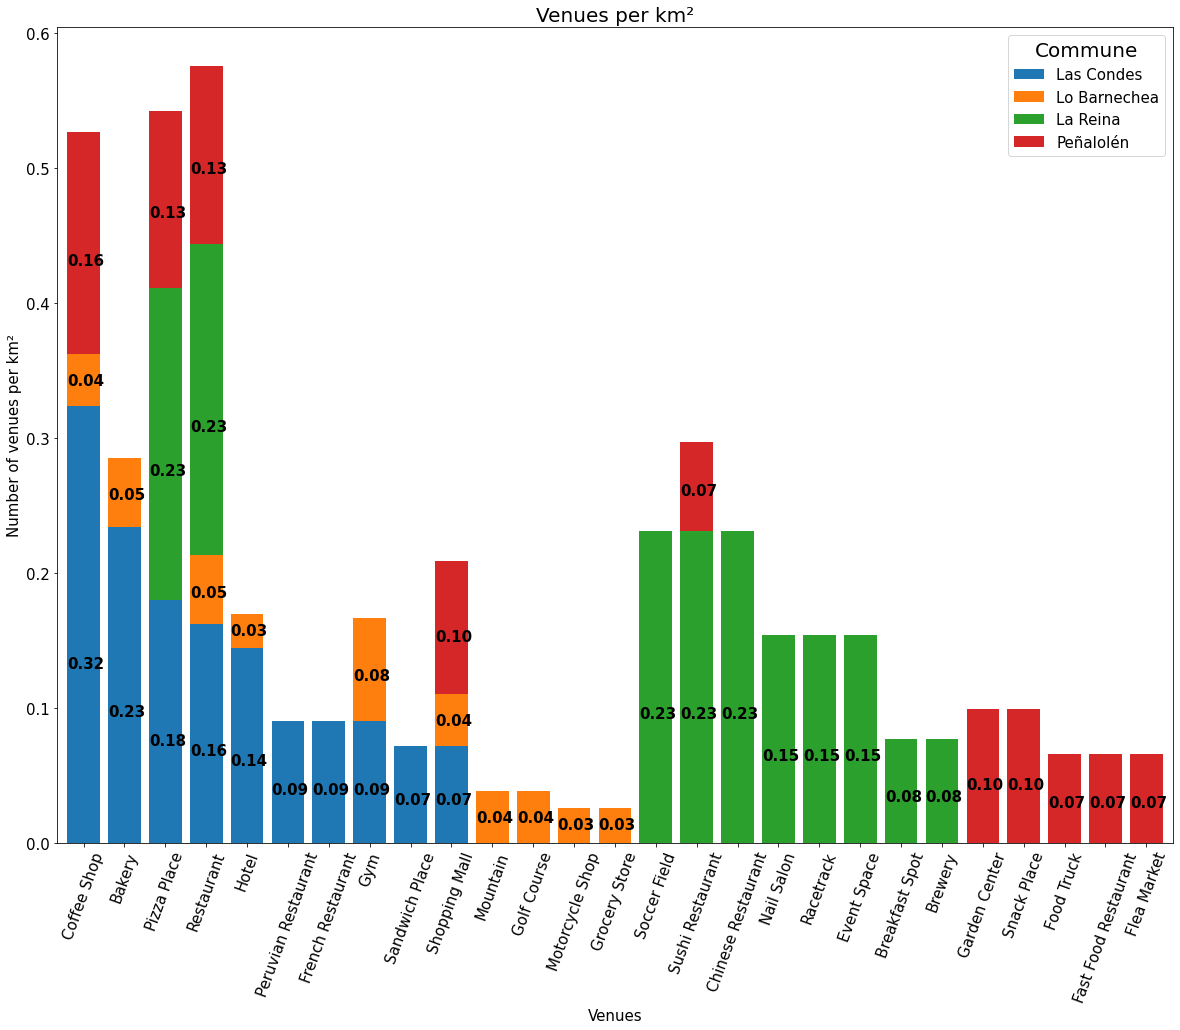

In [228]:
ax = sims_plot.plot.bar(rot=70, figsize=(20,15), width=0.8, stacked=True, fontsize = 15)
ax.set_title('Venues per km²', fontsize = 20)
ax.set_ylabel('Number of venues per km²', fontsize = 15)
ax.set_xlabel('Venues', fontsize = 15)
plt.legend(fontsize = 15, title='Commune') 
plt.rcParams['legend.title_fontsize'] = 20

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    if height != 0:
        ax.annotate('{:.2f}'.format(height), (p.get_x()+0*width, p.get_y()+.4*height), 
                fontsize=15, fontweight='bold', color='black')
ax

The previous chart show us the ten most frequent venues per commune stacked.
We can see that several frequent venues of Las Condes are also present in other communes, with some exceptions.
**The three most frequent stacked venues are: Restaurant, Pizza Place and Coffee Shop**, and they are three of the four most frequent venues of Las Condes, so maybe these venues are not a good option.

We want to find venues that are frequent in the similar communes but not in Las Condes. If we continue seeing the venues of Las Condes, there is one case that is more attractive, this is the **Shopping Mall**. This venue is frequent in Las Condes and it seems to be relatively frequent for the commune of Lo Barnechea and Peñalolén. **The next chart show the relative frequency according to the max frequency of the venues for each commune.**

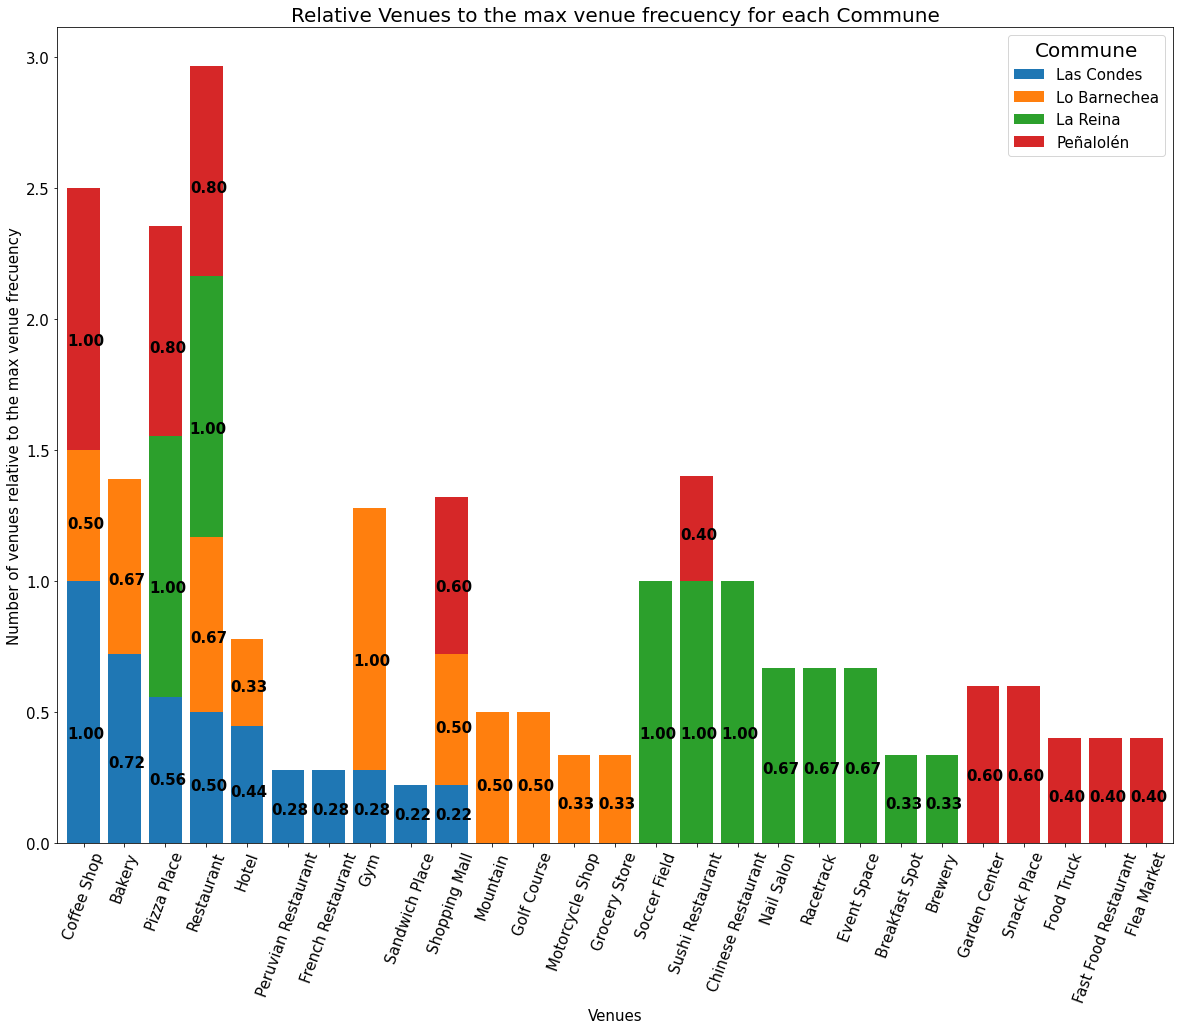

In [236]:
axr = sims_plot2.plot.bar(rot=70, figsize=(20,15), width=0.8, stacked=True, fontsize = 15)
axr.set_title('Relative Venues to the max venue frecuency for each Commune', fontsize = 20)
axr.set_ylabel('Number of venues relative to the max venue frecuency', fontsize = 15)
axr.set_xlabel('Venues', fontsize = 15)
plt.legend(fontsize = 15, title='Commune') 
plt.rcParams['legend.title_fontsize'] = 20

for p in axr.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    if height != 0:
        axr.annotate('{:.2f}'.format(height), (p.get_x()+0*width, p.get_y()+.4*height), 
                fontsize=15, fontweight='bold', color='black')
axr

**In this chart we can see how many venues there are in relation to the most frequent venue per commune**. So if a value is 0.5 for example, this say that there are 0.5 venues for each most frequent venue in that commune. This give us a better understand of the relative importance of the venues in each commune.

We continue with the **Shopping Mall**. Now we see that Lo Barnechea and Peñalolén have more than Las Condes, so maybe this tell us that there are space to put another shopping mall, it could be an option to a great stakeholder with a good economic situation. 

The same with the **Gym**, in Lo Barnechea this is the most frequent venue (1 value), in contrast to Las Condes there are 0.28 gyms for each most common venue (Coffee Shop), so the Gym is another option for future venues.

Then we observe the venues that are not present in Las Condes but are frequent in the similar communes. If we see the venues of **Lo Barnechea**, there are four possible venues: Mountain, Golf Course, Motorcycle Shop and Grocery Store. We will focus in venues that are possible shop or do not require very large spaces, so we rule out the Mountain because this depend of the the geography of the commune, and the Golf Course because we need a large area for this one. Then we have two possible venues: **Grocery Store and Motorcycle Shop**.

We continue with **La Reina**. This commune show **three main options: Soccer field, Sushi Restaurant and Chinese Restaurant**. The **Soccer Field** require a considerable area compared to shops, but it can be located within the city, so it does not rule out as an option, this venue is also one of the most frequent venues of La Reina. The **Sushi Restaurant** is frequent also in Peñalolén, so this is a great possible venue. Finally the **Chinese Restaurant** is another of the most frequent venues of the commune, so it could be a good option. Other options but not as frequent as the previous mentioned are: **Nail Salon, Racetrack, Event Space, Breakfast Spot and Brewery**.

Finally we have the venues of **Peñalolén**. In this commune we have **two main venues** that are not present in Las Condes: **Garden Center and Snack Place**, both of them are feasible option. Then we have other three frequent venues: **Food Truck, Fast Food Restaurant and Flea Market.**

The **client or stakeholder** have different option, then **they can rule out the venues that are out of their budget**, for example the Shopping Mall could exceed the client's budget.

Perhaps the client have some **possible location point** where they'd want to place the venue. Then we can evaluate these points and explore for different option venues that the client want to analyze (with the Foursquare API) and compare which location point have less of the same category venue that we want to place. So, for example, if the client wants to place a Chinese Restaurant, then **we can look for strategic points** that have fewer Chinese Restaurants around them.

## Conclusion <a name="conclusion"></a>

**The purpose** of this Project is to **evaluate new opportunities for future venues in the city of Santiago, Chile**. The client is interested in opening a new venue in Santiago, specifically in the **commune of Las Condes**.

So we analyzed the data and obtained that **the three most similar communes to Las Condes are: Lo Barnechea, La Reina and Peñalolén**. Then we extracted the **ten most frequent venues per commune** and search the venues that are frequent in the similar communes but not in Las Condes. We analyzed these venues and **got the following results**:
- The **Shopping Malls and Gyms** are venues that are frequent in Las Condes but it could be space to place one of them if we compare in a relative way with the other communes.
- **Lo Barnechea**: the main possible venues are **Grocery Store and Motorcycle Shop**.
- **La Reina**: this commune suggest three main options; **Soccer field, Sushi Restaurant and Chinese Restaurant**. Other less frequent options are; **Nail Salon, Racetrack, Event Space, Breakfast Spot and Brewery**.
- **Peñalolén**: the two main venues are **Garden Center and Snack Place**. Other good options are **Food Truck, Fast Food Restaurant and Flea Market**.

We presented **seven main venues** according the three communes and other **ten more options** that are good options but not as frequent as the main options. We have a **total of 17 possible venues** that the client can choose.

Then the client can rule out the venues that are out of their budget. Finally we can continue the analysis looking for **strategic points** in Las Condes that have fewer venues nearby of the same category that the client want. 